# Clustering Metric

This notebook will try to come up with some clustering metric such that we can determine if the dots are truley random or have some clustering structure.

Start with background thresh
Then with deconvolution
then further thresh for binarization
then morphological operations on this to close any gaps 


then spatial cluster the near bloc based on k-means. take the spatial location of each point with its

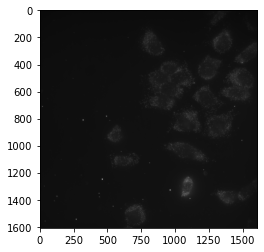

In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndi
import skimage.io as skio
import skimage.measure as skmeasure
import skimage.morphology as skmorph

import matplotlib.pyplot as plt
import astropy.stats as apstats

import warnings

warnings.filterwarnings('ignore')
import sys 
sys.path.append("/Users/shaider/merfish_code/exp_img_reports")

import utils.imgproc as helpers

img = skio.imread('/Users/shaider/Downloads/1hrs_647.TIFF')
plt.imshow(img,cmap='gray',vmin=0)
plt.show()

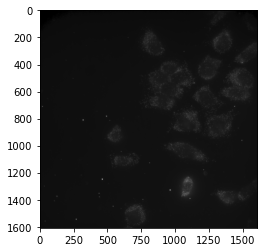

In [2]:
background_thresh = 3000

img_bgthresh = np.where(img>background_thresh,img,0)
plt.imshow(img_bgthresh,cmap='gray',vmin=0)
plt.show()


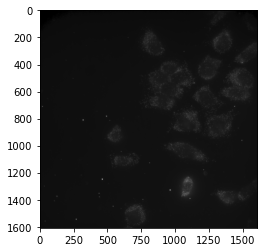

In [3]:
psf = None

img_deconvolve = img_bgthresh#helpers.deconvolve_img(img_bgthresh,psf)
plt.imshow(img_deconvolve,cmap='gray',vmin=0)
plt.show()

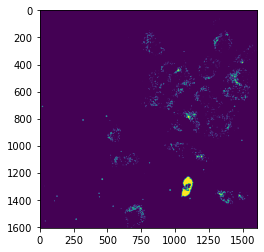

In [4]:

percentile = 99

binary_thresh = np.percentile(img_deconvolve,percentile)

img_binarised = np.where(img_deconvolve>binary_thresh,1,0)

plt.imshow(img_binarised)
plt.show()

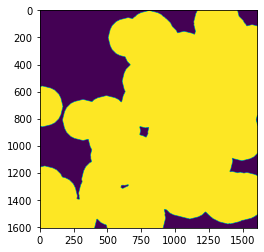

In [5]:
opening_rounds = 15
opening_selem = skmorph.disk(radius =10)


img_morphed = img_binarised.copy()


for _ in range(opening_rounds):
    img_morphed = skmorph.binary_dilation(img_morphed,selem=opening_selem)

erosion_selem = skmorph.disk(radius = 3)
img_morphed = skmorph.binary_erosion(img_morphed,selem=erosion_selem)


plt.imshow(img_morphed)
plt.show()

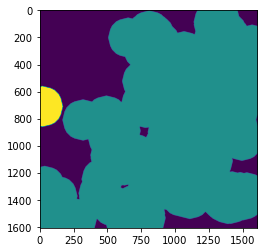

In [6]:
img_labelled = skmeasure.label(img_morphed)
plt.imshow(img_labelled)
plt.show()

2


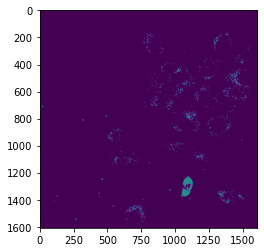

In [7]:
img_label_groups = np.multiply(img_labelled,img_binarised)
num_groups = img_label_groups.max()

print(num_groups)
plt.imshow(img_label_groups)
plt.show()

In [8]:
# #for each label, get the x-y coords, then run it through the astropy kestimator
# r = np.linspace(0, 5, 500)

# Kest = apstats.RipleysKEstimator(area=25)

# f,ax = plt.subplots()
# plt.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
# for c in range(num_groups):
#     group_img = np.where(img_label_groups==c,img_label_groups,0)
#     data_pts = np.transpose(np.nonzero(group_img))
#     plt.plot(r, Kest(data=data_pts, radii=r, mode='none'),
#          label=fr'$C_{c}$')

# plt.legend()
# plt.show()

Try out sklearn metrics like

1. calinski harabasz score
1. davies bouldin score
1. silouette score

Get a mask of pixel locations with a label

Get pixel locations as a (pixels, (r,c))
Get labels as a vector as (pixels,1)

apply the mask to exclude the pixels with zero labels


In [9]:
import sklearn.metrics as metrics

label_mask = np.where(img_label_groups>0,1,0)
filt_labels = np.where(img_label_groups>0,img_label_groups,0)

feat_mat = np.transpose(np.nonzero(label_mask))
labels = np.ravel(filt_labels[filt_labels>0],'C')


In [10]:

chs = metrics.calinski_harabasz_score(feat_mat,labels) # Ratio of within cluster dispersion to between cluster dispersion. Affected by distance between cells. Higher if cells are closer together and higher if dense spots.
dbs = metrics.davies_bouldin_score(feat_mat,labels) # lower the value, the better. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero, with lower values indicating better clustering.
ss = metrics.silhouette_score(feat_mat,labels) # The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

print(chs)
print(dbs)
print(ss)

189.0588191076573
0.40053843072906736
0.47615489207987477


In [11]:
def clusering_metric_exp(img_binarised=img_binarised,radius=10,opening_rounds=15):
    
    opening_selem = skmorph.disk(radius =radius)


    img_morphed = img_binarised.copy()


    for _ in range(opening_rounds):
        img_morphed = skmorph.binary_dilation(img_morphed,selem=opening_selem)

    erosion_selem = skmorph.disk(radius = 3)
    img_morphed = skmorph.binary_erosion(img_morphed,selem=erosion_selem)

    img_labelled = skmeasure.label(img_morphed)
    img_label_groups = np.multiply(img_labelled,img_binarised)
    label_mask = np.where(img_label_groups>0,1,0)
    filt_labels = np.where(img_label_groups>0,img_label_groups,0)

    feat_mat = np.transpose(np.nonzero(label_mask))
    labels = np.ravel(filt_labels[filt_labels>0],'C')
    chs = metrics.calinski_harabasz_score(feat_mat,labels)
    dbs = metrics.davies_bouldin_score(feat_mat,labels)
    ss = metrics.silhouette_score(feat_mat,labels)

    return chs,dbs,ss


test_radii = np.arange(1,7)
test_rounds = np.arange(1,25)

chs_img = np.zeros((len(test_radii),len(test_rounds)))
dbs_img = np.zeros_like(chs_img)
ss_img= np.zeros_like(chs_img)

for ir, tr in enumerate(test_radii):
    for ior, tor in enumerate(test_rounds):
        chs_img[ir,ior], dbs_img[ir,ior],ss_img[ir,ior] = clusering_metric_exp(img_binarised,radius=tr,opening_rounds=tor)
        


Text(0, 0.5, 'Elem Radius')

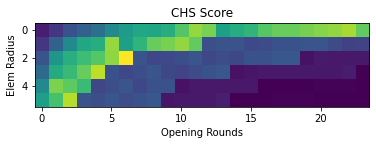

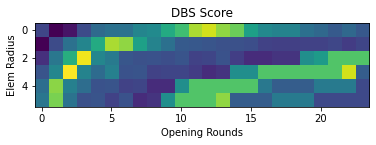

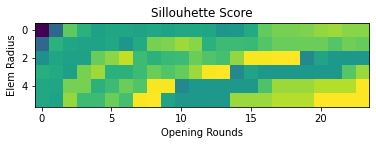

In [12]:

plt.figure()
plt.imshow(chs_img)
plt.title('CHS Score')
plt.xlabel('Opening Rounds')
plt.ylabel('Elem Radius')
plt.figure()
plt.imshow(dbs_img)
plt.title('DBS Score')
plt.xlabel('Opening Rounds')
plt.ylabel('Elem Radius')
plt.figure()
plt.imshow(ss_img)
plt.title('Sillouhette Score')
plt.xlabel('Opening Rounds')
plt.ylabel('Elem Radius')

In [37]:
#Extract the indices

np.argmax(chs_img)
np.argmax(dbs_img)
np.argmax(ss_img)

r,c = np.unravel_index([np.argmax(chs_img),
                        np.argmin(dbs_img),
                        np.argmax(ss_img)],chs_img.shape)
print(f"Best Radii: {r}")
print(f"Best Rounds: {c}")


Best Radii: [2 0 4]
Best Rounds: [ 6  1 23]


In [23]:
def clusering_metric_eval(img_binarised=img_binarised,radius=10,opening_rounds=15):
    
    opening_selem = skmorph.disk(radius =radius)


    img_morphed = img_binarised.copy()


    for _ in range(opening_rounds):
        img_morphed = skmorph.binary_dilation(img_morphed,selem=opening_selem)

    erosion_selem = skmorph.disk(radius = 3)
    img_morphed = skmorph.binary_erosion(img_morphed,selem=erosion_selem)

    img_labelled = skmeasure.label(img_morphed)
    img_label_groups = np.multiply(img_labelled,img_binarised)

    return img_label_groups,img_labelled

Text(0.5, 1.0, 'SS_MAX \n radius=5, rounds=24')

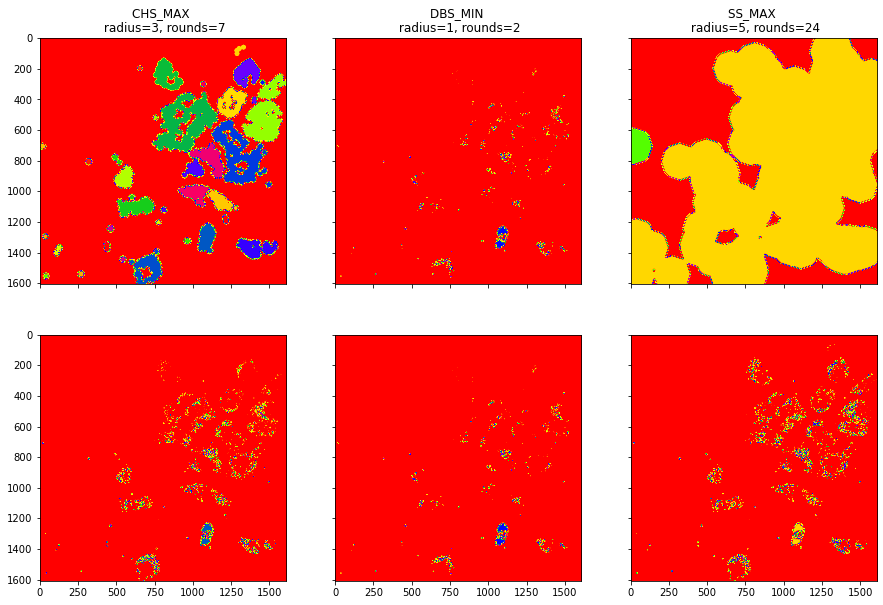

In [26]:
%matplotlib inline
fig,ax=plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,10))

img_label_groups,img_labelled=clusering_metric_eval(radius = test_radii[r[0]],opening_rounds= test_rounds[c[0]])
ax[0,0].imshow(img_labelled,cmap='prism')
ax[1,0].imshow(img_label_groups,cmap='prism')
ax[0,0].set_title(f'CHS_MAX \n radius={test_radii[r[0]]}, rounds={test_rounds[c[0]]}')
img_label_groups,img_labelled=clusering_metric_eval(radius = test_radii[r[1]],opening_rounds= test_rounds[c[1]])
ax[0,1].imshow(img_labelled,cmap='prism')
ax[1,1].imshow(img_label_groups,cmap='prism')
ax[0,1].set_title(f'DBS_MIN \n radius={test_radii[r[1]]}, rounds={test_rounds[c[1]]}')
img_label_groups,img_labelled=clusering_metric_eval(radius = test_radii[r[2]],opening_rounds= test_rounds[c[2]])
ax[0,2].imshow(img_labelled,cmap='prism')
ax[1,2].imshow(img_label_groups,cmap='prism')
ax[0,2].set_title(f'SS_MAX \n radius={test_radii[r[2]]}, rounds={test_rounds[c[2]]}')

According to the image above, it apears that CHS is the best score for us to use when we consider the compactness of the spots

But we still need to investigate a contra example with the same parameters

Let's use an image from a 'relatively' bad run 

In [33]:
def print_metrics(img_label_groups):    
    label_mask = np.where(img_label_groups>0,1,0)
    filt_labels = np.where(img_label_groups>0,img_label_groups,0)

    feat_mat = np.transpose(np.nonzero(label_mask))
    labels = np.ravel(filt_labels[filt_labels>0],'C')
    chs = metrics.calinski_harabasz_score(feat_mat,labels)
    dbs = metrics.davies_bouldin_score(feat_mat,labels)
    ss = metrics.silhouette_score(feat_mat,labels)
    return chs,dbs,ss

(24647.352452461113, 0.4195939978738831, 0.4108945160013991)
(4094.3914486615504, 0.3097788176041674, 0.003176813708047185)
(189.0588191076573, 0.40053843072906736, 0.47615489207987477)


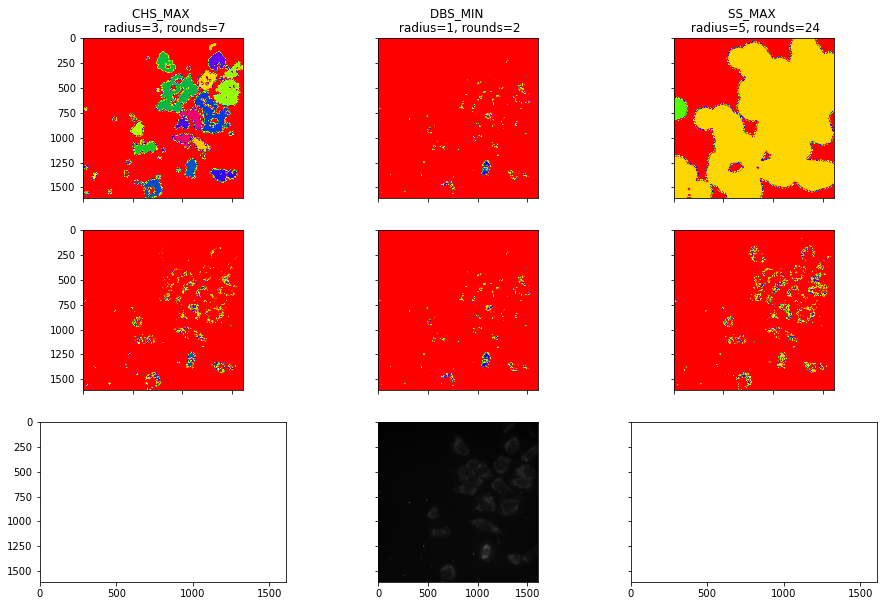

In [43]:
img = skio.imread('/Users/shaider/Downloads/1hrs_647.TIFF')
background_thresh = 3000

img_bgthresh = np.where(img>background_thresh,img,0)

psf = None

img_deconvolve = img_bgthresh
percentile = 99

binary_thresh = np.percentile(img_deconvolve,percentile)
img_binarised = np.where(img_deconvolve>binary_thresh,1,0)
fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=(15,15))

img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[0]],opening_rounds= test_rounds[c[0]])
print(print_metrics(img_label_groups))
ax[0,0].imshow(img_labelled,cmap='prism')
ax[1,0].imshow(img_label_groups,cmap='prism')
ax[0,0].set_title(f'CHS_MAX \n radius={test_radii[r[0]]}, rounds={test_rounds[c[0]]}')
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[1]],opening_rounds= test_rounds[c[1]])
ax[0,1].imshow(img_labelled,cmap='prism')
ax[1,1].imshow(img_label_groups,cmap='prism')
ax[0,1].set_title(f'DBS_MIN \n radius={test_radii[r[1]]}, rounds={test_rounds[c[1]]}')
print(print_metrics(img_label_groups))
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[2]],opening_rounds= test_rounds[c[2]])
ax[0,2].imshow(img_labelled,cmap='prism')
ax[1,2].imshow(img_label_groups,cmap='prism')
ax[0,2].set_title(f'SS_MAX \n radius={test_radii[r[2]]}, rounds={test_rounds[c[2]]}')

ax[2,1].imshow(img,cmap='gray')
print(print_metrics(img_label_groups))



(456.31017919474635, 0.23832547265487397, 0.34604591407249347)
(274.1838117906293, 0.584252125290582, -0.47463188815497315)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

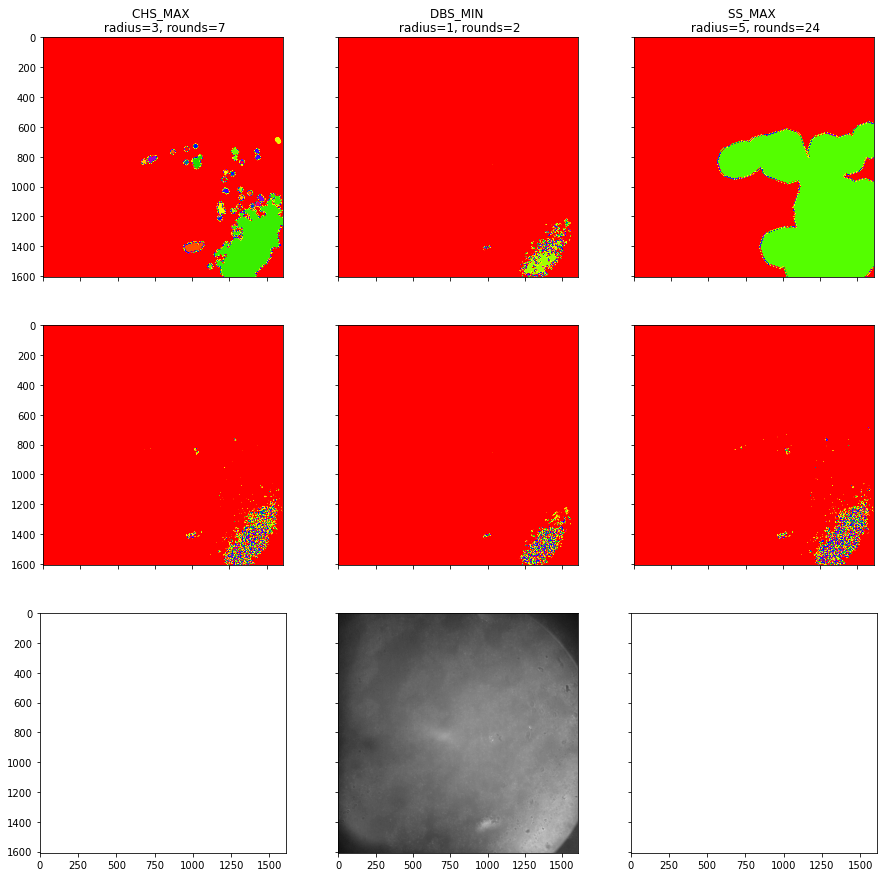

In [46]:
img = skio.imread('/Volumes/MERFISH_COLD/XP1257/bit 3&4/1/1/647nm, Raw/merFISH_01_001_05.TIFF')
background_thresh = 3000

img_bgthresh = np.where(img>background_thresh,img,0)

psf = None

img_deconvolve = img_bgthresh
percentile = 99

binary_thresh = np.percentile(img_deconvolve,percentile)
img_binarised = np.where(img_deconvolve>binary_thresh,1,0)
fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=(15,15))

img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[0]],opening_rounds= test_rounds[c[0]])
print(print_metrics(img_label_groups))
ax[0,0].imshow(img_labelled,cmap='prism')
ax[1,0].imshow(img_label_groups,cmap='prism')
ax[0,0].set_title(f'CHS_MAX \n radius={test_radii[r[0]]}, rounds={test_rounds[c[0]]}')
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[1]],opening_rounds= test_rounds[c[1]])
ax[0,1].imshow(img_labelled,cmap='prism')
ax[1,1].imshow(img_label_groups,cmap='prism')
ax[0,1].set_title(f'DBS_MIN \n radius={test_radii[r[1]]}, rounds={test_rounds[c[1]]}')
print(print_metrics(img_label_groups))
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[2]],opening_rounds= test_rounds[c[2]])
ax[0,2].imshow(img_labelled,cmap='prism')
ax[1,2].imshow(img_label_groups,cmap='prism')
ax[0,2].set_title(f'SS_MAX \n radius={test_radii[r[2]]}, rounds={test_rounds[c[2]]}')
ax[2,1].imshow(img,cmap='gray')
print(print_metrics(img_label_groups))




(472.9543149377352, 0.28139978080392747, 0.17162658754032725)
(618.9294458305029, 0.5294816120096568, -0.3775483276853696)
(81.38651184579327, 0.14625140813403129, 0.8099647729338351)


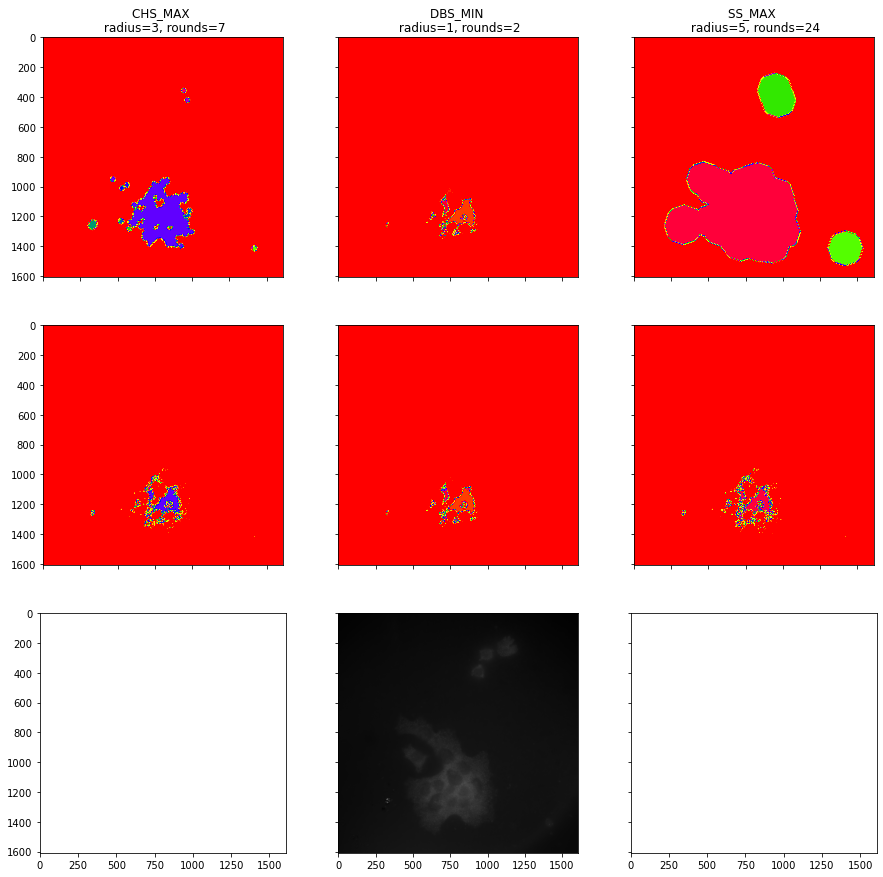

In [45]:
img = skio.imread('/Volumes/MERFISH_COLD/XP872/20210917 4T1 C1E1/4T1/C1E1/647nm, Raw/merFISH_01_001_02.TIFF')
background_thresh = 3000

img_bgthresh = np.where(img>background_thresh,img,0)

psf = None

img_deconvolve = img_bgthresh
percentile = 99

binary_thresh = np.percentile(img_deconvolve,percentile)
img_binarised = np.where(img_deconvolve>binary_thresh,1,0)
fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=(15,15))

img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[0]],opening_rounds= test_rounds[c[0]])
print(print_metrics(img_label_groups))
ax[0,0].imshow(img_labelled,cmap='prism')
ax[1,0].imshow(img_label_groups,cmap='prism')
ax[0,0].set_title(f'CHS_MAX \n radius={test_radii[r[0]]}, rounds={test_rounds[c[0]]}')
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[1]],opening_rounds= test_rounds[c[1]])
ax[0,1].imshow(img_labelled,cmap='prism')
ax[1,1].imshow(img_label_groups,cmap='prism')
ax[0,1].set_title(f'DBS_MIN \n radius={test_radii[r[1]]}, rounds={test_rounds[c[1]]}')
print(print_metrics(img_label_groups))
img_label_groups,img_labelled=clusering_metric_eval(img_binarised=img_binarised,radius = test_radii[r[2]],opening_rounds= test_rounds[c[2]])
ax[0,2].imshow(img_labelled,cmap='prism')
ax[1,2].imshow(img_label_groups,cmap='prism')
ax[0,2].set_title(f'SS_MAX \n radius={test_radii[r[2]]}, rounds={test_rounds[c[2]]}')
print(print_metrics(img_label_groups))

ax[2,1].imshow(img,cmap='gray')
